$u_t = -uu_x - u_{xx} - u_{xxxx}$

In [85]:
import matplotlib.pyplot as plt

# General imports
import numpy as np
import torch

# DeePyMoD imports
from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.data.burgers import burgers_delta
from deepymod.model.constraint import LeastSquares
from deepymod.model.func_approx import NN, Siren
from deepymod.model.library import Library1D
from deepymod.model.sparse_estimators import Threshold
from deepymod.training import train
from deepymod.training.sparsity_scheduler import Periodic, TrainTest, TrainTestPeriodic
from scipy.io import loadmat
import pysindy as ps

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cuda


In [86]:
def load_data():
    data = loadmat("../../PDE-READ/Matlab/Data/KS_Cos.mat")
    time = np.ravel(data["t"]).squeeze()
    x = np.ravel(data["x"]).squeeze()
    array = {}
    array["x"], array["t"] = np.meshgrid(x, time, indexing="ij")
    array["u"] = data["usol"]
    array["x"].shape, array["t"].shape, array["u"].shape
    coords = torch.from_numpy(np.stack((array["t"], array["x"]), axis=-1)).float()
    data = torch.from_numpy(np.real(array["u"])).unsqueeze(-1).float()
    return coords, data

In [87]:
dataset = Dataset(
    load_data,
    subsampler=Subsample_random,
    subsampler_kwargs={"number_of_samples": 4000},
    device=device,
)

Preprocessing data
Dataset is using device:  cuda


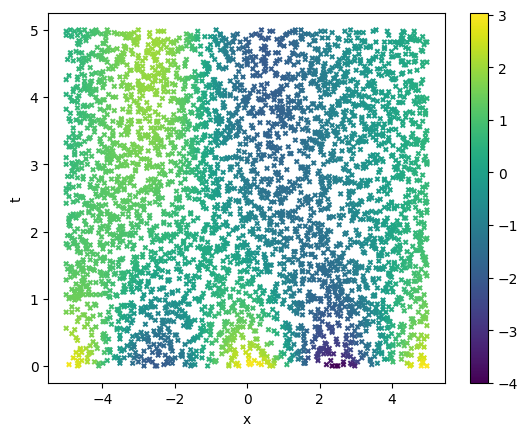

In [88]:
coords = dataset.get_coords().cpu()
data = dataset.get_data().cpu()
fig, ax = plt.subplots()
im = ax.scatter(coords[:, 1], coords[:, 0], c=data[:, 0], marker="x", s=10)
ax.set_xlabel("x")
ax.set_ylabel("t")
fig.colorbar(mappable=im)

plt.show()

In [89]:
train_dataloader, test_dataloader = get_train_test_loader(dataset, train_test_split=0.8)

In [90]:
network = NN(2, [50, 50, 50, 50], 1)

In [91]:
library = Library1D(poly_order=1, diff_order=4)

In [92]:
estimator = Threshold(0.3)
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5)

In [93]:
constraint = LeastSquares()
# Configuration of the sparsity scheduler

In [94]:
model = DeepMoD(network, library, estimator, constraint).to(device)

# Defining optimizer
optimizer = torch.optim.Adam(
    model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3
)

In [95]:
%%time
!rm -rf ./data/deepymod/Kuramoto_Sivashinsky_Cos/
foldername = "./data/deepymod/Kuramoto_Sivashinsky_Cos/"
train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    sparsity_scheduler,
    log_dir=foldername,
    split=0.8,
    max_iterations=100000,
)

 99975  MSE: 3.11e-03  Reg: 1.91e-04  L1: 5.46e+01 Algorithm converged. Writing model to disk.
CPU times: user 1h 22min 38s, sys: 50.5 s, total: 1h 23min 28s
Wall time: 1h 22min 44s


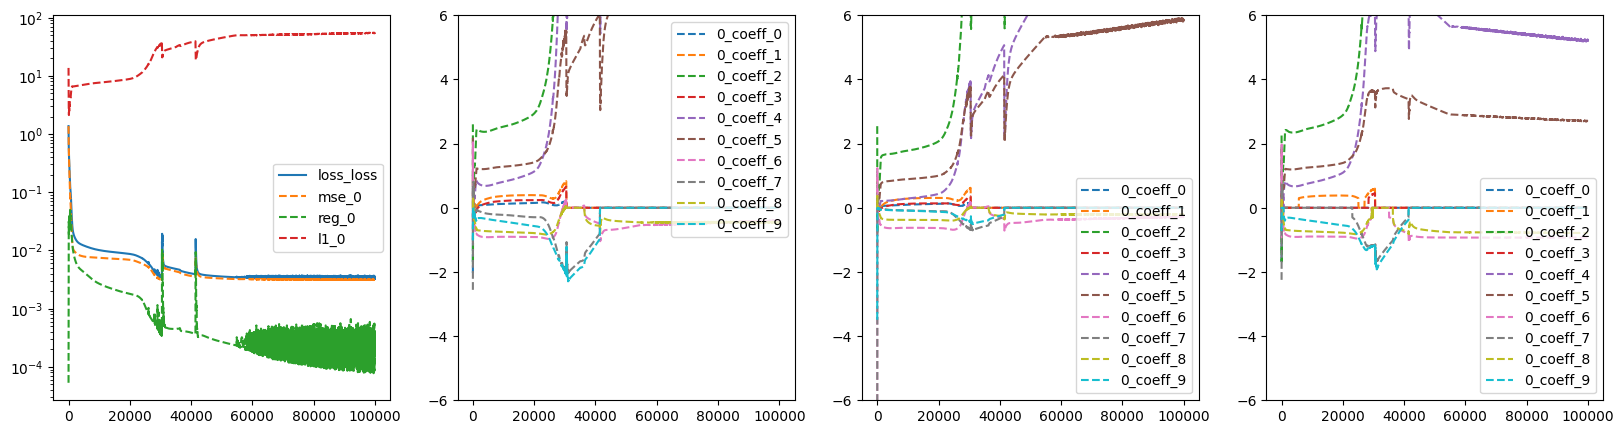

In [96]:
from deepymod.analysis import load_tensorboard

history = load_tensorboard(foldername)
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for history_key in history.keys():
    history_key_parts = history_key.split("_")
    if history_key_parts[0] == "loss":
        if history_key_parts[-1] == "0":
            axs[0].semilogy(
                history[history_key],
                label=history_key_parts[1] + "_" + history_key_parts[-1],
                linestyle="--",
            )
        elif history_key_parts[-1] == "1":
            axs[0].semilogy(
                history[history_key],
                label=history_key_parts[1] + "_" + history_key_parts[-1],
                linestyle=":",
            )
        else:
            axs[0].semilogy(
                history[history_key],
                label=history_key_parts[1] + "_" + history_key_parts[-1],
                linestyle="-",
            )
        if history_key_parts[0] == "remaining":
            axs[0].semilogy(
                history[history_key],
                label=history_key_parts[1]
                + "_"
                + history_key_parts[3]
                + "_"
                + history_key_parts[4],
                linestyle="-.",
            )
    if history_key_parts[0] == "coeffs":
        if history_key_parts[2] == "0":
            axs[1].plot(
                history[history_key],
                label=history_key_parts[2]
                + "_"
                + history_key_parts[3]
                + "_"
                + history_key_parts[4],
                linestyle="--",
            )
        elif history_key_parts[2] == "1":
            axs[1].plot(
                history[history_key],
                label=history_key_parts[2]
                + "_"
                + history_key_parts[3]
                + "_"
                + history_key_parts[4],
                linestyle=":",
            )
        else:
            axs[1].plot(
                history[history_key],
                label=history_key_parts[2]
                + "_"
                + history_key_parts[3]
                + "_"
                + history_key_parts[4],
                linestyle="-",
            )
    if history_key_parts[0] == "unscaled":
        if history_key_parts[3] == "0":
            axs[2].plot(
                history[history_key],
                label=history_key_parts[3]
                + "_"
                + history_key_parts[4]
                + "_"
                + history_key_parts[5],
                linestyle="--",
            )
        elif history_key_parts[3] == "1":
            axs[2].plot(
                history[history_key],
                label=history_key_parts[3]
                + "_"
                + history_key_parts[4]
                + "_"
                + history_key_parts[5],
                linestyle=":",
            )
        else:
            axs[2].plot(
                history[history_key],
                label=history_key_parts[3]
                + "_"
                + history_key_parts[4]
                + "_"
                + history_key_parts[5],
                linestyle="-",
            )
    if history_key_parts[0] == "estimator":
        if history_key_parts[3] == "0":
            axs[3].plot(
                history[history_key],
                label=history_key_parts[3]
                + "_"
                + history_key_parts[4]
                + "_"
                + history_key_parts[5],
                linestyle="--",
            )
        elif history_key_parts[3] == "1":
            axs[3].plot(
                history[history_key],
                label=history_key_parts[3]
                + "_"
                + history_key_parts[4]
                + "_"
                + history_key_parts[5],
                linestyle=":",
            )
        else:
            axs[3].plot(
                history[history_key],
                label=history_key_parts[3]
                + "_"
                + history_key_parts[4]
                + "_"
                + history_key_parts[5],
                linestyle="-",
            )

# axs[0].set_ylim([-2, 2])
axs[1].set_ylim([-6, 6])
axs[2].set_ylim([-6, 6])
axs[3].set_ylim([-6, 6])

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()

plt.show()

The physical coefficients for the equation
$u_t = -uu_x - u_{xx} - u_{xxxx}$
given the library 
* [$1, u_x, \textcolor{blue}{u_{xx}}, u_{xxx}, \textcolor{blue}{u_{xxxx}}, u, \textcolor{blue}{u u_{x}}, u u_{xx}, u u_{xxx}, u u_{xxxx}$]

In [97]:
model.constraint_coeffs()

[tensor([[ 0.0000],
         [ 0.0000],
         [17.3189],
         [ 0.0000],
         [ 7.7634],
         [ 5.9054],
         [-0.2761],
         [ 0.0000],
         [-0.2039],
         [ 0.0000]], device='cuda:0', grad_fn=<MaskedScatterBackward0>)]

In [98]:
model.estimator_coeffs()

[array([[ 0.        ],
        [ 0.        ],
        [ 8.016345  ],
        [ 0.        ],
        [ 5.2070804 ],
        [ 2.7031496 ],
        [-0.9282548 ],
        [ 0.        ],
        [-0.78458756],
        [ 0.        ]], dtype=float32)]